In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from datetime import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
#import ace_tools as tools

In [2]:
# Load the dataset
file_path = 'austinhouses.csv'
austin_houses = pd.read_csv(file_path)

# Handling Categorical Variables
categorical_features = ['homeType', 'hasAssociation', 'hasGarage', 'hasSpa', 'hasView']
one_hot_encoder = OneHotEncoder()

# Feature Interaction
austin_houses['area_bedrooms_interaction'] = austin_houses['livingAreaSqFt'] * austin_houses['numOfBedrooms']
austin_houses['school_rating_distance_interaction'] = austin_houses['avgSchoolRating'] * austin_houses['avgSchoolDistance']
austin_houses['bed_bath_story_interaction'] = austin_houses['numOfBedrooms'] * austin_houses['numOfBathrooms'] * austin_houses['numOfStories']

# Temporal Features
current_year = datetime.now().year
austin_houses['house_age'] = current_year - austin_houses['yearBuilt']

# Extract season from latest_saledate
austin_houses['latest_saledate'] = pd.to_datetime(austin_houses['latest_saledate'])
austin_houses['sale_month'] = austin_houses['latest_saledate'].dt.month
austin_houses['season'] = austin_houses['sale_month'] % 12 // 3 + 1

# Geospatial Features
# Clustering based on latitude and longitude
coords = austin_houses[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=10, random_state=42)
austin_houses['neighborhood'] = kmeans.fit_predict(coords)

# Text Features
# Description Analysis: Extracting sentiment using TextBlob and TF-IDF vectorization
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
austin_houses['description'] = austin_houses['description'].astype(str)
tfidf_vectorizer = TfidfVectorizer(max_features=100)
description_tfidf = tfidf_vectorizer.fit_transform(austin_houses['description']).toarray()
description_tfidf_df = pd.DataFrame(description_tfidf, columns=tfidf_vectorizer.get_feature_names_out())

# Aggregated Features
# Mean/Median/Count of numerical features grouped by zipcode
zipcode_group = austin_houses.groupby('zipcode').agg({
    'livingAreaSqFt': ['mean', 'median', 'count'],
    'latestPrice': ['mean', 'median']
}).reset_index()
zipcode_group.columns = ['_'.join(col) for col in zipcode_group.columns]

austin_houses = austin_houses.merge(zipcode_group, left_on='zipcode', right_on='zipcode_')

# Normalization/Scaling
scaler = StandardScaler()
scaled_features = ['livingAreaSqFt', 'lotSizeSqFt', 'avgSchoolDistance', 'avgSchoolRating', 'numOfBathrooms', 'numOfBedrooms', 'numOfStories']
austin_houses[scaled_features] = scaler.fit_transform(austin_houses[scaled_features])

# Missing Values Handling
imputer = SimpleImputer(strategy='median')
austin_houses[scaled_features] = imputer.fit_transform(austin_houses[scaled_features])

# Drop unnecessary columns
austin_houses = austin_houses.drop(columns=['streetAddress', 'description', 'latest_saledate', 'zipcode_'])

# Encode categorical variables
encoded_categorical = one_hot_encoder.fit_transform(austin_houses[categorical_features])
encoded_categorical_df = pd.DataFrame(encoded_categorical.toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_features))

# Concatenate all engineered features into the final dataframe
final_df = pd.concat([austin_houses.reset_index(drop=True), encoded_categorical_df, description_tfidf_df], axis=1)
final_df = final_df.drop(columns=categorical_features)

# Display the final dataframe
#tools.display_dataframe_to_user(name="Engineered Austin Houses Dataset", dataframe=final_df)

final_df.head()

[nltk_data] Downloading package punkt to /Users/pranvgarg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pranvgarg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,zipcode,latitude,longitude,garageSpaces,yearBuilt,latestPrice,latest_salemonth,latest_saleyear,numOfPhotos,numOfAccessibilityFeatures,...,upstairs,walk,was,windows,with,wood,yard,you,your,zestimate
0,78717,30.495638,-97.797874,0,2008,400.0,1,2020,20,0,...,0.000000,0.140746,0.0,0.000000,0.000000,0.151037,0.0,0.000000,0.0,0.0
1,78717,30.488775,-97.794899,2,2013,549.9,3,2018,69,0,...,0.190769,0.000000,0.0,0.000000,0.191551,0.164850,0.0,0.000000,0.0,0.0
2,78725,30.233154,-97.587318,2,1999,240.0,12,2020,10,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,78725,30.238237,-97.578331,2,2012,200.0,1,2018,33,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,78726,30.426456,-97.859291,2,2004,875.0,11,2020,38,0,...,0.232543,0.000000,0.0,0.102821,0.175122,0.100474,0.0,0.334571,0.0,0.0


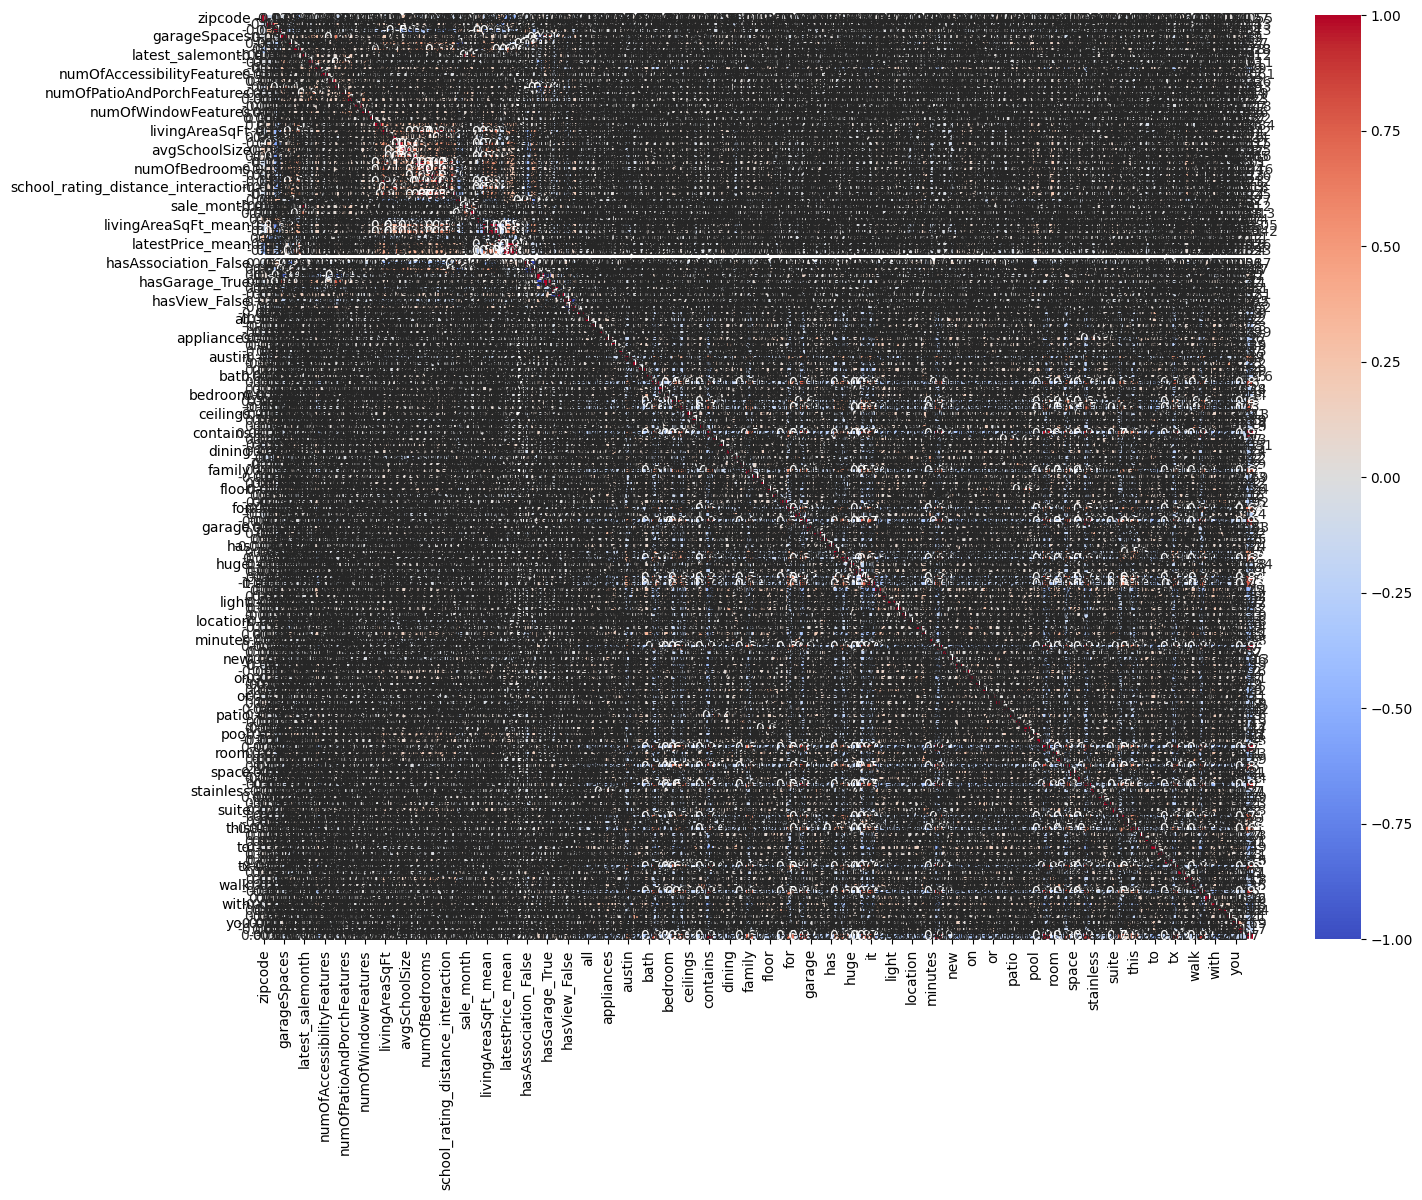

In [3]:

# Calculate correlation matrix
corr_matrix = final_df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Mean Squared Error: 35315.49350121382
R-squared: 0.699596873198967


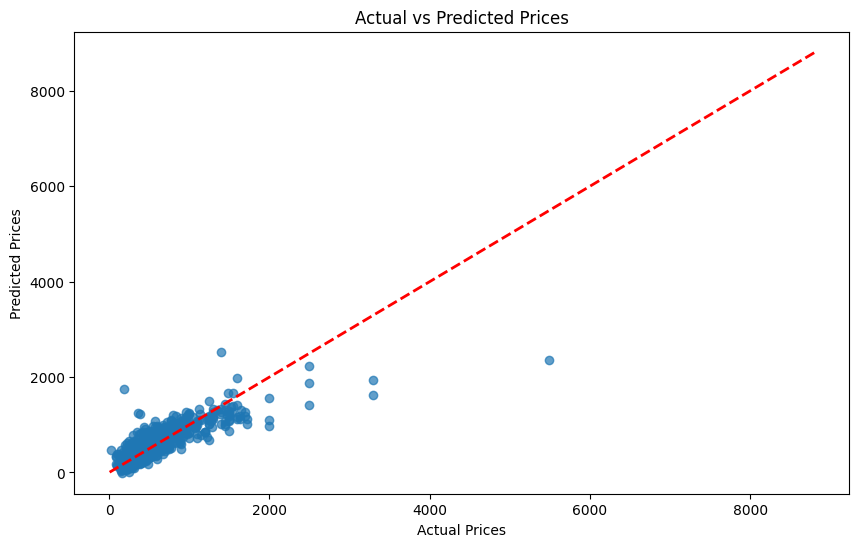

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the engineered dataset
# Assuming final_df is already created from the previous steps

# Prepare the data
X = final_df.drop(columns=['latestPrice'])
y = final_df['latestPrice']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Optionally, display predictions vs actuals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

Mean Squared Error: 45656.514146123525


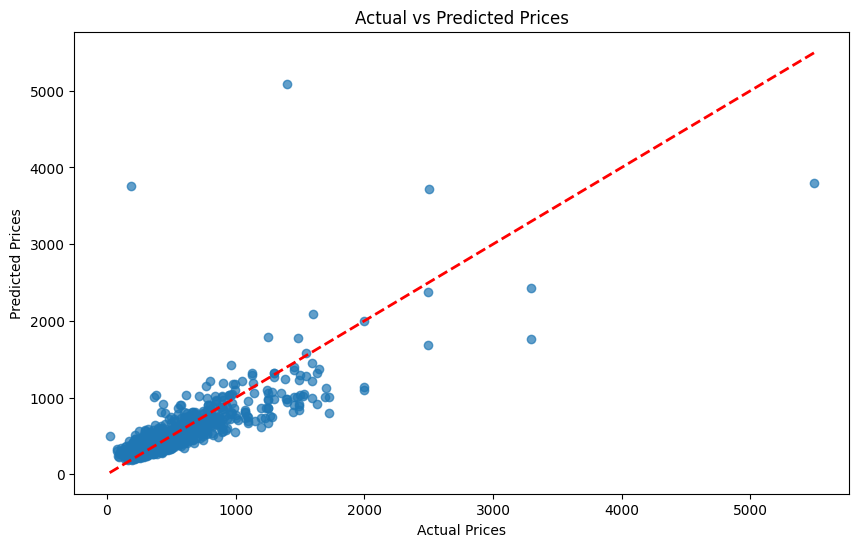

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the engineered dataset
# Assuming final_df is already created from the previous steps

# Prepare the data
X = final_df[['latitude', 'longitude', 'latest_saleyear', 'numOfPhotos',
       'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 'numOfStories',
       'bed_bath_story_interaction', 'livingAreaSqFt_mean',
       'livingAreaSqFt_count', 'latestPrice_mean', 'hasAssociation_False',
       'hasAssociation_True', 'hasGarage_False', 'hasGarage_True', 'an',
       'area', 'granite', 'home', 'huge', 'pool', 'room', 'sq', 'the',
       'upstairs', 'was']]
y = np.log(final_df['latestPrice'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred_log = model.predict(X_test)

# Inverse Transform the Predictions
y_pred = np.exp(y_pred_log)

# Calculate MSE on the original scale
mse = mean_squared_error(np.exp(y_test), y_pred)
print(f'Mean Squared Error: {mse}')

# Optionally, display predictions vs actuals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(np.exp(y_test), y_pred, alpha=0.7)
plt.plot([min(np.exp(y_test)), max(np.exp(y_test))], [min(np.exp(y_test)), max(np.exp(y_test))], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

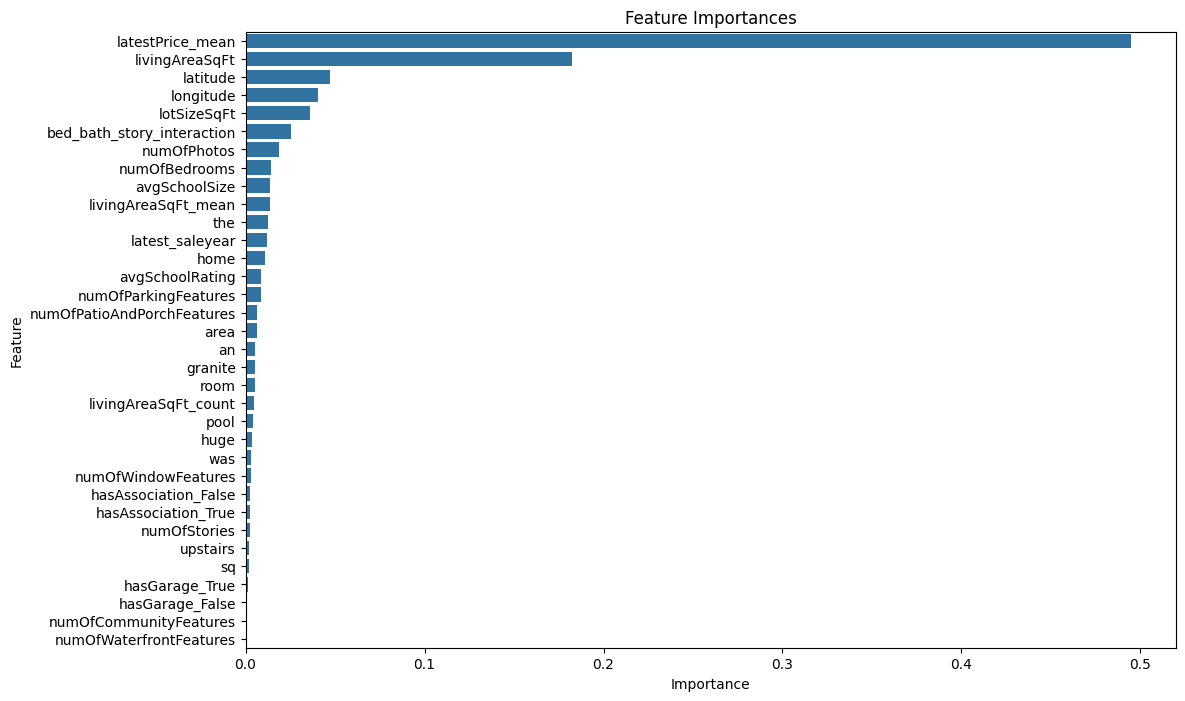

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

In [7]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Use RFE with a linear regression model
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X.columns[rfe.support_]

print(f'Selected Features: {selected_features}')

Selected Features: Index(['longitude', 'numOfWaterfrontFeatures', 'livingAreaSqFt',
       'hasAssociation_False', 'hasAssociation_True', 'granite', 'pool',
       'room', 'sq', 'the'],
      dtype='object')


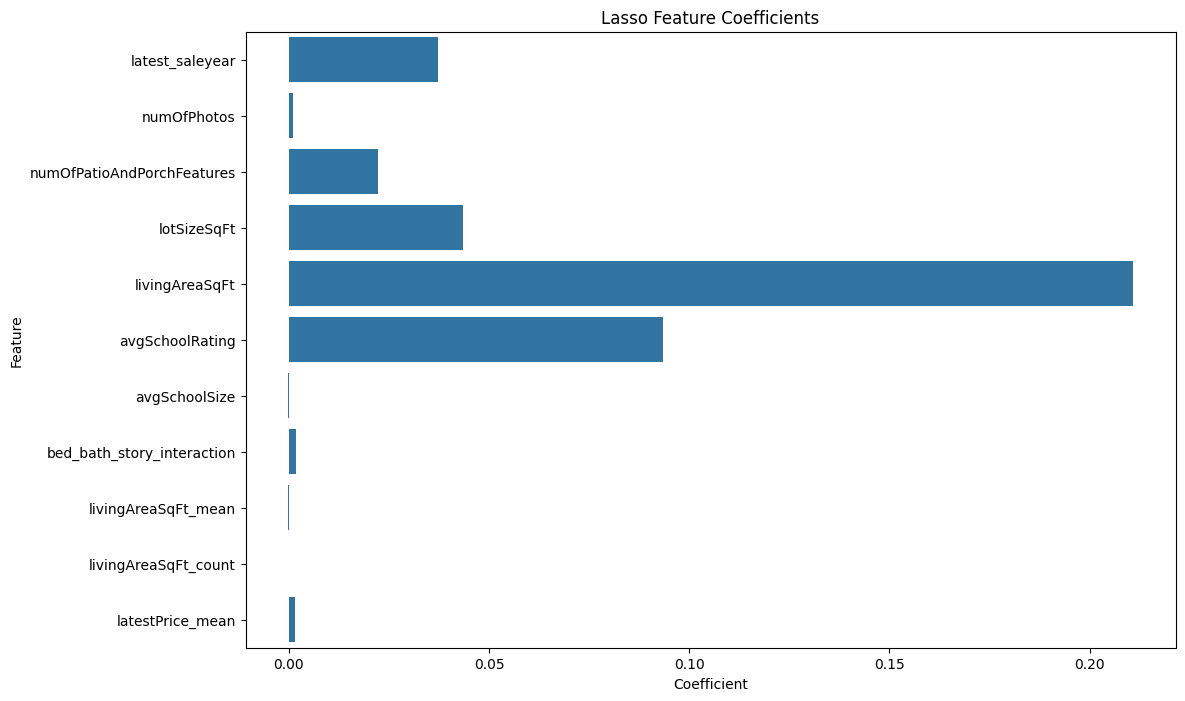

In [8]:
from sklearn.linear_model import Lasso

# Train a Lasso model
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)

# Get coefficients
lasso_coefficients = lasso_model.coef_

# Create a DataFrame for visualization
lasso_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_coefficients})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0]

# Plot non-zero coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=lasso_df)
plt.title('Lasso Feature Coefficients')
plt.show()

In [9]:
import statsmodels.api as sm

# Add constant for intercept
X_train_const = sm.add_constant(X_train)

# Train OLS model
ols_model = sm.OLS(y_train, X_train_const).fit()

# Get p-values
p_values = ols_model.pvalues

# Filter features with p-values < 0.05
significant_features = p_values[p_values < 0.05].index

print(f'Significant Features: {significant_features}')

Significant Features: Index(['const', 'latitude', 'longitude', 'latest_saleyear', 'numOfPhotos',
       'numOfPatioAndPorchFeatures', 'numOfWaterfrontFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 'numOfStories',
       'bed_bath_story_interaction', 'livingAreaSqFt_mean',
       'livingAreaSqFt_count', 'latestPrice_mean', 'hasAssociation_False',
       'hasAssociation_True', 'hasGarage_False', 'hasGarage_True', 'an',
       'area', 'pool', 'the'],
      dtype='object')
